In [ ]:
# https://arxiv.org/pdf/2205.14173.pdf

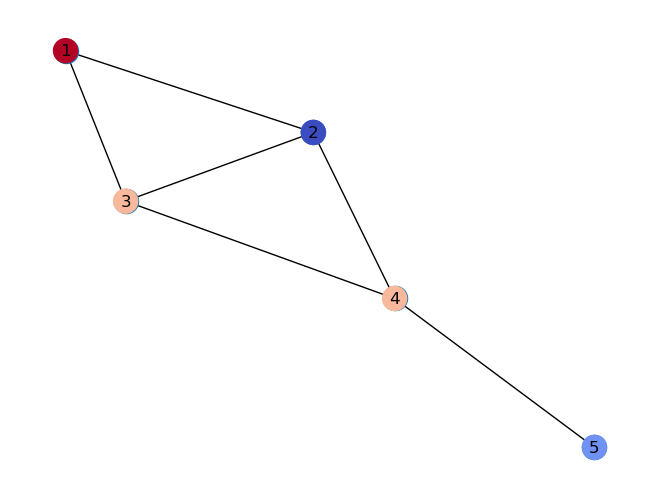

In [528]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Create an empty graph
G = nx.Graph()

# Add 5 vertices to the graph
G.add_nodes_from([1, 2, 3, 4, 5])

# Add edges between the vertices
G.add_edges_from([(1, 2), (1, 3), (2, 3), (2, 4), (3, 4), (4, 5)])

# Construct the Laplacian matrix
L = nx.laplacian_matrix(G).toarray()

# Find the eigenvectors of the Laplacian matrix
eigenvalues, eigenvectors = np.linalg.eig(L)

# Get the second eigenvector
second_eigenvector = eigenvectors[:, 0]

# Plot the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)

# Highlight the nodes based on the second eigenvector
# node_colors = ['r' if v > 0 else 'b' for v in second_eigenvector]
# nx.draw_networkx_nodes(G, pos, node_color=node_colors)

# make node colors continuous

node_colors = second_eigenvector
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.coolwarm)


# Show the plot
plt.show()


In [2]:
eigenvectors@eigenvectors.T

array([[ 1.00000000e+00,  3.83815955e-16,  8.80288308e-17,
        -1.38777878e-16, -3.60822483e-16],
       [ 3.83815955e-16,  1.00000000e+00, -1.66533454e-16,
        -2.29934717e-17,  2.17282501e-16],
       [ 8.80288308e-17, -1.66533454e-16,  1.00000000e+00,
        -3.10073436e-16,  1.99051133e-16],
       [-1.38777878e-16, -2.29934717e-17, -3.10073436e-16,
         1.00000000e+00,  1.94289029e-16],
       [-3.60822483e-16,  2.17282501e-16,  1.99051133e-16,
         1.94289029e-16,  1.00000000e+00]])

In [456]:
import torch

from StiefelOptimizers import StiefelAdam, StiefelSGD



In [631]:
import torch.nn as nn

class InfinityNormModel(nn.Module):
    def __init__(self, init_vectors):
        super(InfinityNormModel, self).__init__()
        # Initialize the weight matrix as a parameter
        self.weight_matrix = nn.Parameter(torch.tensor(init_vectors, dtype=torch.float32))
        # self.weight_matrix.name = 'weight_matrix'
        self.register_parameter('weight_matrix', self.weight_matrix)

    def forward(self):
        # Compute the infinity norm of the weight matrix
        infinity_norm = torch.max(torch.sum(torch.abs(self.weight_matrix), dim=1))
        return infinity_norm

# Create a model instance with a 5x5 weight matrix
init_vectors = eigenvectors[0:3, :]
model = InfinityNormModel(init_vectors)

# Forward pass to compute the infinity norm
infinity_norm = model()
print(f"The infinity norm of the weight matrix is: {infinity_norm.item()}")


# Print the name and value of each parameter
for name, param in model.named_parameters():
    print(f"Name: {name}, Value: {param}")

The infinity norm of the weight matrix is: 2.0717883110046387
Name: weight_matrix, Value: Parameter containing:
tensor([[ 4.4721e-01,  4.3753e-01, -7.0308e-01, -3.3800e-01,  3.2518e-17],
        [ 4.4721e-01,  2.5597e-01,  2.4217e-01,  4.1932e-01,  7.0711e-01],
        [ 4.4721e-01,  2.5597e-01,  2.4217e-01,  4.1932e-01, -7.0711e-01]],
       requires_grad=True)


In [632]:
from StiefelOptimizers import StiefelAdam

euclidean_parameters = []
stiefel_parameters = []

# put the Euclidean and Stiefel parameters into 2 different list
for name, param in model.named_parameters():
    if 'weight_matrix' in name:
        # torch.nn.init.orthogonal_(param) # optional
        stiefel_parameters.append(param)
    else:
        euclidean_parameters.append(param)
# optimizer_euclidean=torch.optim.Adam(model.parameters)
# apply our StiefelAdam algorithm
optimizer_stiefel=StiefelAdam(stiefel_parameters, lr=0.001)
# optimizer=CombinedOptimizer(optimizer_euclidean, optimizer_stiefel)

import torch

def infinity_norm_loss(m):
        # Compute the infinity norm of the weight matrix
        # infinity_norm = torch.max(torch.sum(torch.abs(m.weight_matrix), dim=1))
        infinity_norm = -m.weight_matrix[0,0]**2 - m.weight_matrix[0,1]**2 - m.weight_matrix[1,2]**2 - m.weight_matrix[1,3]**2 - m.weight_matrix[2,4]**2
        return infinity_norm

# Test the loss function
loss = infinity_norm_loss(model)
print(f"The infinity norm loss is: {loss.item()}")

The infinity norm loss is: -1.1259106397628784


In [660]:
from tqdm import tqdm

# Set the number of optimization steps
num_steps = 1000

# Create a tqdm progress bar
progress_bar = tqdm(total=num_steps, desc="Optimizing")

optimizer = optimizer_stiefel

# Perform optimization steps
for step in range(num_steps):
        # Clear the gradients
        optimizer.zero_grad()
        
        # Forward pass to compute the loss
        loss = infinity_norm_loss(model)
        
        # Backward pass to compute the gradients
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        #print loss to progress bar
        progress_bar.set_postfix({'loss': loss.item()})

        # Update the progress bar
        progress_bar.update(1)

# Close the progress bar
progress_bar.close()


Optimizing: 100%|██████████| 1000/1000 [00:02<00:00, 408.99it/s, loss=-3]


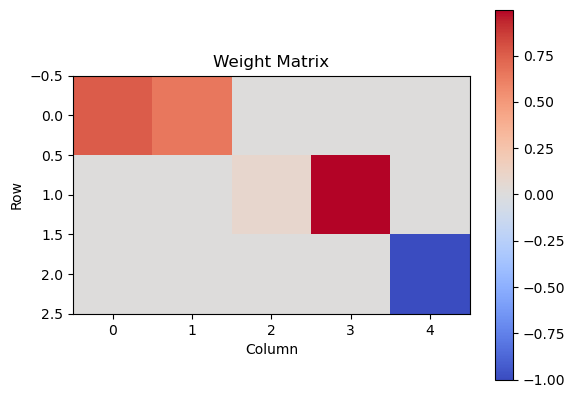

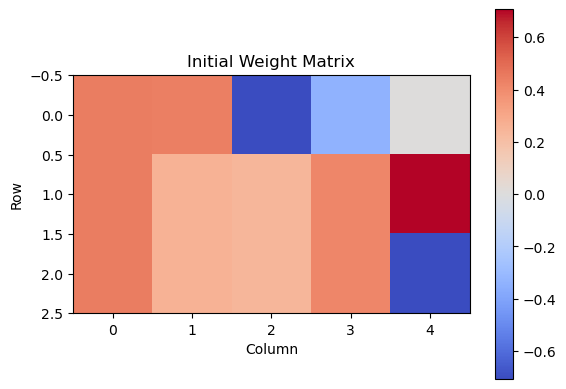

[[ 7.59853423e-01  6.50094390e-01  1.46152552e-05 -5.77333994e-05
   3.10749820e-05]
 [ 4.16806106e-05  3.80527090e-05  7.84446672e-02  9.96918499e-01
   1.12998966e-09]
 [ 3.75210439e-05  3.94447261e-06  1.08959575e-05 -8.57957559e-07
  -1.00000000e+00]]


array([[9.9999988e-01, 3.5114408e-14, 3.6379788e-12],
       [3.5114408e-14, 1.0000000e+00, 6.6613381e-16],
       [3.6379788e-12, 6.6613381e-16, 1.0000000e+00]], dtype=float32)

In [661]:
import matplotlib.pyplot as plt

# Get the weight matrix from the model
weight_matrix = model.weight_matrix.detach().numpy()

# Plot the weight matrix
plt.imshow(weight_matrix, cmap='coolwarm')
plt.colorbar()
plt.title('Weight Matrix')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()


# Plot the initial weight matrix
plt.imshow(init_vectors, cmap='coolwarm')
plt.colorbar()
plt.title('Initial Weight Matrix')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()



print(weight_matrix)

# check orthogonality of rows
weight_matrix = model.weight_matrix.detach().numpy()
np.dot(weight_matrix, weight_matrix.T)

In [ ]:
# # put the Euclidean and Stiefel parameters into 2 different list
# for name, param in net.named_parameters():
#     if 'q.weight' in name or 'k.weight' in name:
#         torch.nn.init.orthogonal_(param) # optional
#         stiefel_parameters.append(param)
#     else:
#         euclidean_parameters.append(param)
# optimizer_euclidean=torch.optim.Adam(model.parameters)
# # apply our StiefelAdam algorithm
# optimizer_stiefel=StiefelAdam(stiefel_parameters)
# optimizer=CombinedOptimizer(optimizer_euclidean, optimizer_stiefel)